<a href="https://colab.research.google.com/github/nehemoro/relu_derivative_at_zero/blob/master/fastai_custom_relu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *

In [0]:
path = untar_data(URLs.IMAGENETTE_160)

In [0]:
size = 64 #px
#lr = 1e-3
bs = 2 #64

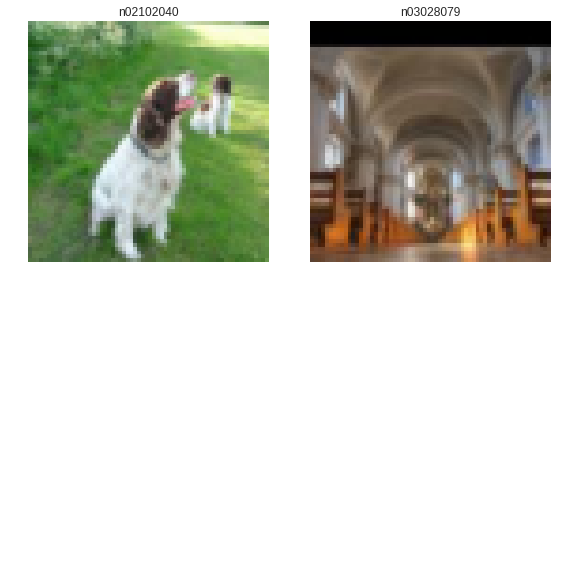

In [14]:
data = (ImageList.from_folder(path).split_by_folder(valid='val')
            .label_from_folder()
            .transform(([flip_lr(p=0.5)], []), size=size)
            .databunch(bs=bs, num_workers=8)
            .presize(size, scale=(0.35,1))
            .normalize(imagenet_stats))
data.show_batch()

In [0]:
#learn = (Learner(data, models.xresnet50(), metrics=[accuracy,top_k_accuracy], wd=1e-3, opt_func=optim.Adam,
         #bn_wd=False, true_wd=True, loss_func = LabelSmoothingCrossEntropy())
        #.mixup(alpha=0.2).to_fp16(dynamic=True))
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
#learn.model

In [0]:
class SaveGradInput():
    #input_grads=[]
    #num_zeros=[]
    def __init__(self, m): 
        self.hook = m.register_backward_hook(self.hook_fn)
        self.input_grads=[]
        self.num_zeros=[]
    def hook_fn(self, module, grad_input, grad_output): 
        n = torch.nonzero(grad_input[0]==0).nelement()
        if n!=0:
            self.input_grads.append(grad_input[0])
        self.num_zeros.append(n)
    def close(self): self.hook.remove()

In [0]:
relu_modules = [module for module in learn.model.modules() if type(module) == nn.ReLU]
relu_hooks=[]
for relu in relu_modules:
    relu_hooks.append(SaveGradInput(relu))

In [18]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiproce

KeyboardInterrupt: ignored

In [0]:
for hook in relu_hooks:
    hook.close()

In [20]:
for i in range(18):
    print(len(relu_hooks[i].num_zeros))
#relu_hooks[3].num_zeros#input_grads

24
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
24


In [31]:
len(relu_hooks[2].input_grads) #[1][0]==0).shape

72

In [40]:
relu_hooks[17].input_grads[0].shape

torch.Size([2, 512])

In [22]:
%debug

> /usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py(90)backward()
     88     Variable._execution_engine.run_backward(
     89         tensors, grad_tensors, retain_graph, create_graph,
---> 90         allow_unreachable=True)  # allow_unreachable flag
     91 
     92 

ipdb> q
